In [1]:
import HTTP
import CSV, JSON
using Gumbo
using Cascadia

using Statistics
using DataFrames
using Pipe
using Dates
using RollingFunctions

using Plots

Plots.default(size = (3000, 2000))
Plots.scalefontsizes(4)

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling RollingFunctions [b0e4dd01-7b14-53d8-9b45-175a3e362653]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [2]:
get_data = url -> begin
    prefix = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

    df = @pipe HTTP.get(prefix * url).body |>
        CSV.File |>
        DataFrame
end

cases_raw = get_data("time_series_covid19_confirmed_global.csv")
deaths_raw = get_data("time_series_covid19_deaths_global.csv")

size(cases_raw), size(deaths_raw)

((273, 374), (273, 374))

In [3]:
country = "Poland"

preprocess = df -> begin    
    df = @pipe df |>
        select(_, Not(["Province/State", "Lat", "Long"])) |>
        rename(_, "Country/Region" => "Country") |>
        filter("Country" => ==(country), _) |>
        stack(_, Not("Country"), variable_name = "Date", value_name = "Count") |>
        groupby(_, "Date") |>  # don't care about provinces
        combine(_, "Count" => sum => "Count")
    
    df[!, "Date"] = map(x -> Date(String(x), dateformat"m/d/y") + Year(2000), df[:, "Date"])
    df
end

cases = preprocess(cases_raw)
deaths = preprocess(deaths_raw)

size(cases), size(deaths)

((370, 2), (370, 2))

In [4]:
diff_same_length(x) = [x[1]; diff(x)]
window_size = 14

data = @pipe leftjoin(cases, deaths, on = ["Date"], makeunique = true) |>
    rename(_,
        "Count" => "Cases",
        "Count_1" => "Deaths",
    ) |>
    sort(_, ["Date"]) |>
    transform(_,
        "Cases" => diff_same_length => "New cases",
        "Deaths" => diff_same_length => "New deaths",
    )

idx = argmax(data[!, "New cases"] .> 0)
data = data[idx:end, :]

,Date,Cases,Deaths,New cases,New deaths
,Date,Int64,Int64?,Int64,Int64
1,2020-03-04,1,0,1,0
2,2020-03-05,1,0,0,0
3,2020-03-06,5,0,4,0
4,2020-03-07,5,0,0,0
5,2020-03-08,11,0,6,0
6,2020-03-09,16,0,5,0
7,2020-03-10,22,0,6,0
8,2020-03-11,31,0,9,0
9,2020-03-12,49,1,18,1


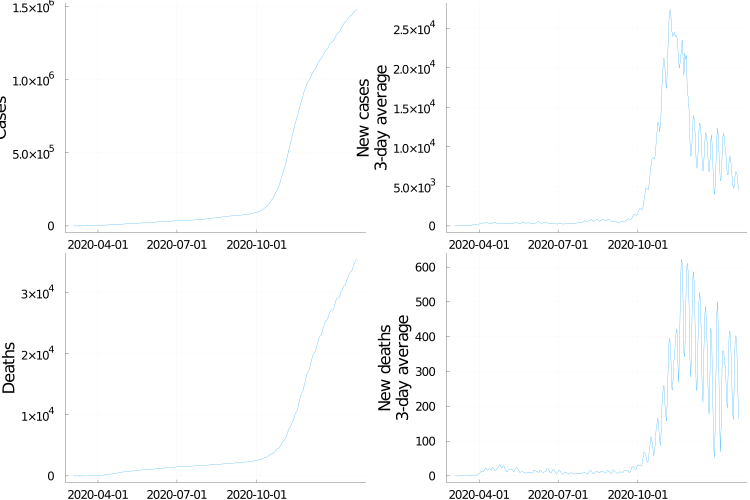

In [5]:
window_size = 3

ticks = [Date(2020, i, 1) for i in 1:3:12]

plot(
    plot(data[!, "Date"], data[!, "Cases"], legend=false, ylab="Cases", xticks=ticks),
    plot(data[!, "Date"], runmean(data[!, "New cases"], window_size), legend=false, ylab="New cases\n$window_size-day average", xticks=ticks),
    plot(data[!, "Date"], data[!, "Deaths"], legend=false, ylab="Deaths", xticks=ticks),
    plot(data[!, "Date"], runmean(data[!, "New deaths"], window_size), legend=false, ylab="New deaths\n$window_size-day average", xticks=ticks),
    layout = (2, 2)
)

In [6]:
column = "New cases"
window_size = 30

x = data[:, column][(end - window_size):(end - 1)]
y = data[:, column][(end - window_size + 1):end]

size(x), size(y)

((30,), (30,))

In [7]:
function add_intercept(X)
    n = size(X, 1)
    hcat(ones(n), X) 
end

function linreg(X, y)
    X \ y
end

β_new_cases = linreg(x, y)
β_new_cases, y[end] * β_new_cases^7, y[end] * β_new_cases^14

(0.9431816781005019, 1775.533590767457, 1178.9527045413538)

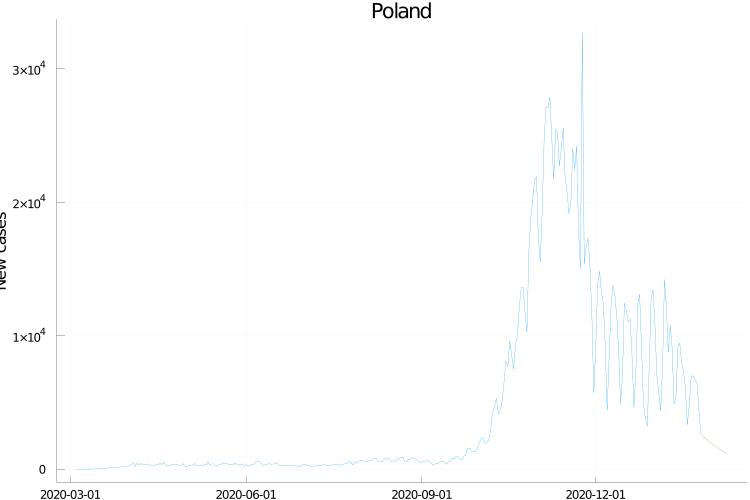

In [8]:
column = "New cases"
pred_window_size = 14
days = map(t -> data[!, "Date"][end] + Day(t), 0:pred_window_size)
pred = y[end] * β_new_cases .^ [0:pred_window_size;]

plot(data[!, "Date"], data[!, column], legend = false, title = country, ylab = column)
plot!(days, pred, legend = false)

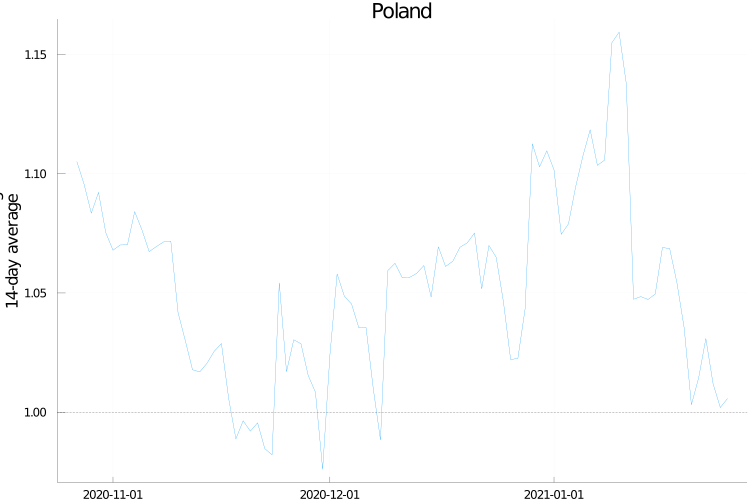

In [9]:
raw_column = "New cases"
column = "$raw_column change"
window_size = 14
show_days = 90

data[!, column] .= 1.0
for row in 2:size(data, 1)
    if data[row - 1, raw_column] == 0
        data[row, column] = NaN
    else
        data[row, column] = data[row, raw_column] / data[row - 1, raw_column]
    end
end

plot(data[end - show_days:end, "Date"], runmean(data[!, column], window_size)[end - show_days:end],
    legend = false, title = country, ylab = "$column\n$window_size-day average")
plot!([1], seriestype = :hline, c = :black, ls = :dash)

In [10]:
?HTTP.Messages.Response

```
Response(status::Int, headers=[]; body=UInt8[], request=nothing) -> HTTP.Response
```

---

```
Response <: Message
```

Represents a HTTP Response Message.

  * `version::VersionNumber`  [RFC7230 2.6](https://tools.ietf.org/html/rfc7230#section-2.6)
  * `status::Int16`  [RFC7230 3.1.2](https://tools.ietf.org/html/rfc7230#section-3.1.2)  [RFC7231 6](https://tools.ietf.org/html/rfc7231#section-6)
  * `headers::Vector{Pair{String,String}}`  [RFC7230 3.2](https://tools.ietf.org/html/rfc7230#section-3.2)
  * `body::Vector{UInt8}`  [RFC7230 3.3](https://tools.ietf.org/html/rfc7230#section-3.3)
  * `request`, the `Request` that yielded this `Response`.

---

```
HTTP.Response(status::Int, body) -> HTTP.Response
```

## Examples

```julia
HTTP.Response(200, "Hello")

headers = ["Server" => "Apache"]
HTTP.Response(200, headers; body = "Hello")
```


In [11]:
# Eurostat: total weekly deaths by week

country_code = "PL"

url = "https://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/demo_r_mwk_ts?geo=$country_code&sex=T"
response = HTTP.get(url)
raw_eurostat_data = response.body |> String |> JSON.parse

response

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Date: Tue, 26 Jan 2021 08:27:37 GMT
Content-Length: 51841
Content-Type: application/json;charset=UTF-8
X-ORACLE-DMS-ECID: dcbc2ab2-f318-4bb1-b3ad-1b41a3c0225a-00003cec
X-ORACLE-DMS-RID: 0
Access-Control-Allow-Methods: GET, POST, OPTIONS
Vary: Accept-Encoding
Access-Control-Allow-Origin: *
Proxy-Connection: Keep-Alive
Connection: Keep-Alive

"""

In [12]:
# See:
# https://ec.europa.eu/eurostat/cache/metadata/en/demomwk_esms.htm
# https://en.wikipedia.org/wiki/ISO_8601#Week_dates

function isoweektodate(date::String)
    year, week = map(x -> parse(Int32, x), split(date, 'W'))
    return firstdayofweek(Date(year)) + Week(week) - Week(1)
end

@assert isoweektodate("2020W01") == Date(2019, 12, 30)
@assert isoweektodate("2020W02") == Date(2020, 1, 6)

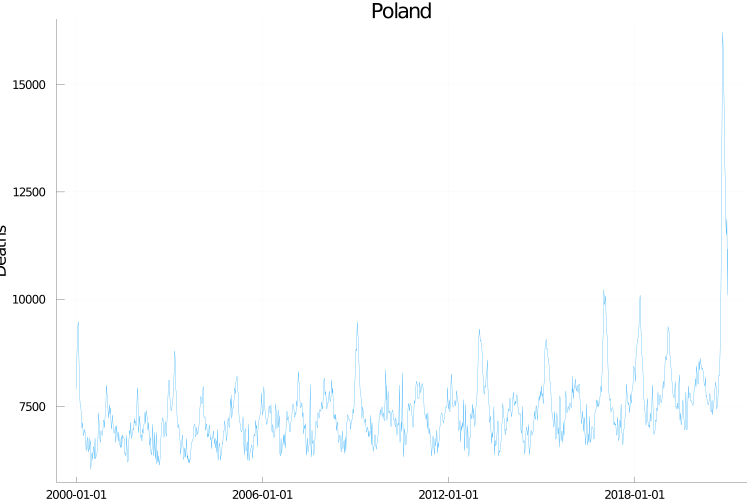

In [13]:
index_to_week = Dict{Int32, String}(index => week for (week, index) in raw_eurostat_data["dimension"]["time"]["category"]["index"])

eurostat = DataFrame("Year" => Int32[], "Week" => Int32[], "Date" => Date[], "Deaths" => Int32[])

for (index, value) in raw_eurostat_data["value"]
    isoweek = index_to_week[parse(Int32, index)]
    date = isoweektodate(isoweek)
    year, week = map(x -> parse(Int32, x), split(isoweek, 'W'))
    push!(eurostat, [year, week, date, value])
end

sort!(eurostat, ["Date"])

plot(eurostat[!, "Date"], eurostat[!, "Deaths"], legend=false, ylab="Deaths", title=country)

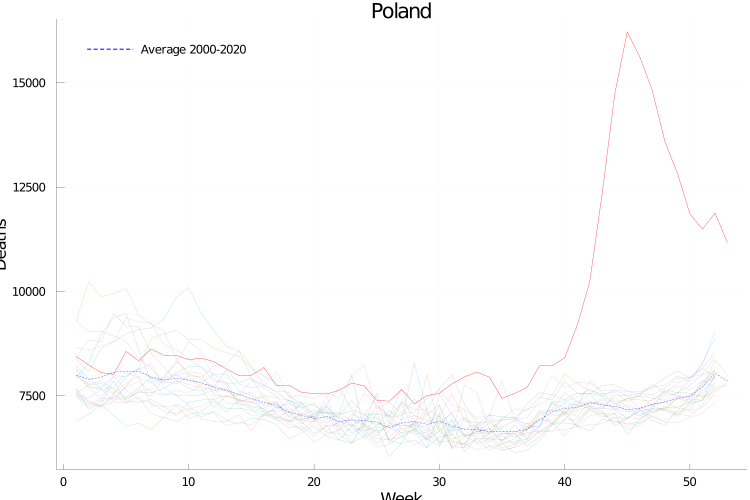

In [14]:
eurostat_years = sort(unique(eurostat[:, "Year"]))

plot(ylab="Deaths", title=country, legend=:topleft, fg_legend = :transparent)

for year in eurostat_years
    tmp = filter("Year" => ==(year), eurostat)
    
    if year == 2020
        kwargs = [:c => :red, :lw => 1.2]
    else
        kwargs = [:alpha => 0.5]
    end
    
    plot!(tmp[!, "Week"], tmp[!, "Deaths"]; label = false, xlab="Week", kwargs...)
end

historical_average = @pipe eurostat |>
    filter("Year" => <(2020), _) |>
    groupby(_, "Week") |>
    combine(_, "Deaths" => mean)

plot!(historical_average[!, "Week"], historical_average[!, "Deaths_mean"],
    label = "Average $(eurostat_years[1])-$(eurostat_years[end]-1)", xlab="Week", c=:blue, lw=1.2, ls=:dash)

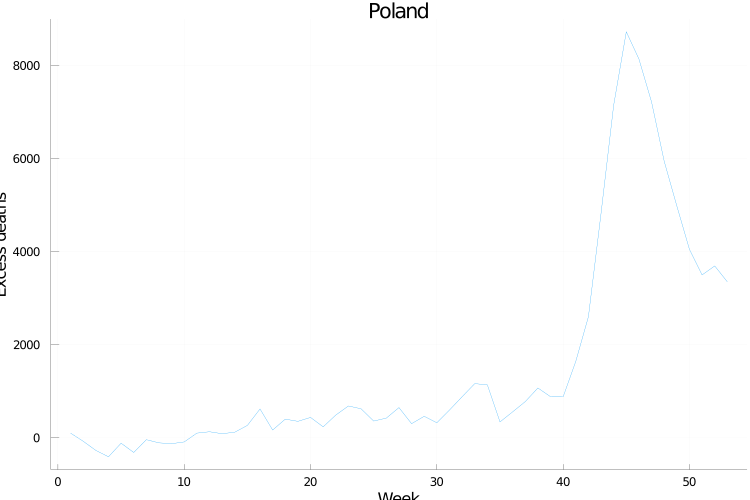

In [15]:
joined_data = @pipe eurostat |>
    filter("Year" => x -> 2014 <= x <= 2019, _) |>
    groupby(_, "Week") |>
    combine(_, "Deaths" => mean) |>
    outerjoin(_, filter("Year" => ==(2020), eurostat), on="Week")

joined_data[!, "Excess deaths"] = joined_data[!, "Deaths"] - joined_data[!, "Deaths_mean"]

plot(joined_data[!, "Week"], joined_data[!, "Excess deaths"], label=false, xlab="Week", ylab="Excess deaths", title=country)

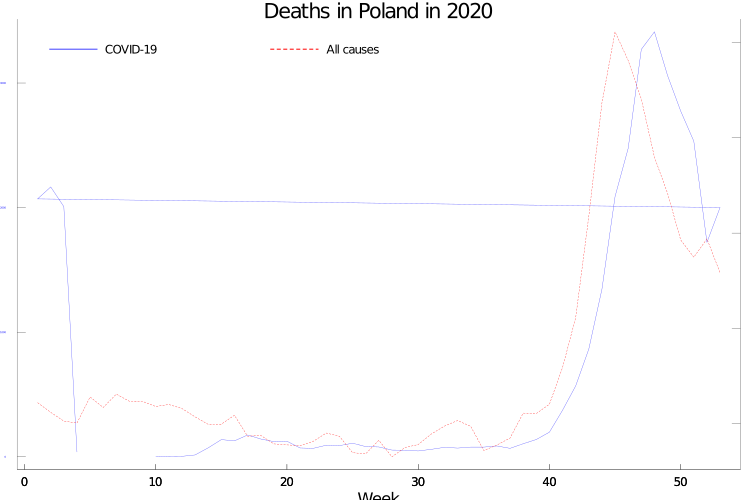

In [16]:
raw_column = "New deaths"
window_size = 7
filter_days = 180

eurostat2020 = filter("Year" => ==(2020), eurostat)

weekly_data = @pipe data |>
    sort(_, "Date") |>
    transform(_, "Date" => (x -> week.(x)) => "Week") |>
    groupby(_, "Week") |>
    combine(_, "New deaths" => sum => "New deaths") |>
    filter("Week" => <=(maximum(eurostat2020[!, "Week"])), _)

plot(weekly_data[!, "Week"], weekly_data[!, "New deaths"], legend=:topleft, fg_legend = :transparent,
    title="Deaths in $country in 2020", label = "COVID-19", grid=false,
    c=:blue, ytickfont=font(7, :blue), xlab="Week", lw=1.2, alpha=0.75)

plot!(twinx(), eurostat2020[!, "Week"], eurostat2020[!, "Deaths"], legend=:top, fg_legend = :transparent,
    label = "All causes", c=:red, grid=false, ls=:dash, lw=1.2, ytickfont = font(7, :red))